# Clone the Entire Repository in Colab

In [ ]:
!git clone https://github.com/patitimoner/workshop-chihuahua-vs-muffin.git
%cd workshop-chihuahua-vs-muffin
!ls

Cloning into 'workshop-chihuahua-vs-muffin'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 337 (delta 1), reused 4 (delta 1), pack-reused 330 (from 1)
Receiving objects: 100% (337/337), 14.51 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/workshop-chihuahua-vs-muffin
'CNN_1 Chihuahua or Muffin.ipynb'   README.md   workshop_1.ipynb
 data				    resources   workshop_1_output.ipynb


# Chihuahua vs Muffin Classifier using Convolutional Neural Networks

# 1. Introduction

In this lab, we'll build upon our previous workshop where we used a traditional Neural Network (NN) to classify images as either Chihuahuas or muffins. This time, we'll use a Convolutional Neural Network (CNN), which is particularly well-suited for image classification tasks because it can learn spatial hierarchies of features directly from the image data.
By the end of this lab, we'll compare the performance of our CNN model with the traditional NN from the previous workshop.

This is what we'll do in this lab:
#### 1) Build the  convolutional neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

Let's get started!

# 2.  Setup and Imports

Let's get to the fun stuff!
First, we need to Install and  import the necessary libraries. Each import serves a specific purpose in our project.
python


In [ ]:
!pip install torch --upgrade
!pip install torchvision --upgrade

In [ ]:
import numpy as np                          # Numpy for matrix operations
import torch                                 # PyTorch deep learning framework
import torch.nn as nn                        # Neural network module of PyTorch
import torch.optim as optim                  # Optimization algorithms
from torchvision import datasets, transforms # Tools for loading and transforming image data
from torch.utils.data import DataLoader      # Efficient data loading
import matplotlib.pyplot as plt              # For plotting and visualization. It is graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline
from tqdm import tqdm                        # For progress bars during training

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 3 Data Preparation
Before we start training our model, it's crucial to separate our data into training and testing (validation) sets. This separation is a fundamental concept in machine learning that helps us assess how well our model generalizes to unseen data.

## 3.1 Understanding Train-Test Split
In machine learning, we typically divide our dataset into two main subsets:

1. **Training set:** This is the larger portion of the data that we use to train our model. The model learns the patterns and features from this data.
2. **Testing set** (also called Validation set): This is a smaller portion of the data that we set aside and don't use during training. We use this to evaluate how well our model performs on unseen data.

The reason for this split is to simulate how our model would perform on new, unseen data in the real world. If we tested on the same data we used for training, we wouldn't know if our model was truly learning general patterns or just memorizing the training data (a problem called overfitting).



In [ ]:
import os

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

# Count the number of images in each set
train_chihuahuas = len(os.listdir("data/train/chihuahua"))
train_muffins = len(os.listdir("data/train/muffin"))
val_chihuahuas = len(os.listdir("data/validation/chihuahua"))
val_muffins = len(os.listdir("data/validation/muffin"))

print(f"Training set: {train_chihuahuas} Chihuahuas, {train_muffins} Muffins")
print(f"Validation set: {val_chihuahuas} Chihuahuas, {val_muffins} Muffins")

Data contents: ['validation', 'train']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']
Training set: 65 Chihuahuas, 55 Muffins
Validation set: 17 Chihuahuas, 13 Muffins



## 3.2 Dataset Structure
In our case, we've already separated our data into train and validation sets in our file structure:
You should see that we have two main directories (same dataset as previous exercise): 'train' and 'validation', each containing subdirectories for our classes (Chihuahua and Muffin).

## 3.3 Loading Separated Datasets
Now, let's load our separated datasets:
Remember we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

## 3.4 Define Data transformations
Now that we understand our dataset, let's define the transformations we'll apply to our images. These transformations help in data augmentation and normalization.
**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.


In [ ]:
from torchvision import transforms
#  Define image dimensions
input_height, input_width = 224, 224

# Define data transforms for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_height, input_width)),  # Resize images
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ]),
    'validation': transforms.Compose([
        transforms.Resize((input_height, input_width)),  # Resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
}

## 3.5 Create Dataset and Dataloader
With our transformations defined, we can now create our datasets and dataloaders. These will efficiently feed data into our model during training.

In [ ]:
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'])
}

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=4)
}

# Get the number of classes
num_classes = len(image_datasets['train'].classes)
print(f"Number of classes: {num_classes}")

# Print dataset sizes
print(f"Training samples: {len(image_datasets['train'])}")
print(f"Validation samples: {len(image_datasets['validation'])}")

Number of classes: 2
Training samples: 120
Validation samples: 30


### Let's break down what this code does:

1. We define separate data transforms for training and validation sets. The training set includes data augmentation (random flips and rotations) to increase variety in our training data, while the validation set doesn't use augmentation.

2. We use datasets.ImageFolder to load our images from the 'train' and 'validation' directories. This function automatically assigns labels based on the subdirectory names.

3. We create DataLoader objects for both sets. These handle batching our data and shuffling the training set (but not the validation set, as order doesn't matter for validation).

4. Finally, we print the sizes of our datasets to confirm the split.

By using separate dataloaders for training and validation, we ensure that our model is evaluated on data it hasn't seen during training, giving us a more accurate assessment of its performance.

# 4. Model Definition
Now that we've prepared our data, we can define our CNN model. We'll use the information about our input dimensions and number of classes to structure our network.

In [ ]:
class ChihuahuaMuffinCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=num_classes):
        super(ChihuahuaMuffinCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * (input_height//8) * (input_width//8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # Pass input through convolutional layers
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass through the fully connected layers
        return x

# Initialize the model and move it to the appropriate device
model = ChihuahuaMuffinCNN().to(device)
print(model)

# Print model summary
from torchsummary import summary
summary(model, (3, input_height, input_width))

ChihuahuaMuffinCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU

# 5. Training Setup
With our model defined, we now need to set up our loss function and optimizer. These are crucial components for training our network. In deep learning, they are the  two key components for training: Let's  recap and understand what these are and how we'll use them.

**Loss Function**
The loss function measures how well our model is performing. It calculates the difference between our model's predictions and the true labels. For our classification task, we'll use Cross Entropy Loss, which is well-suited for multi-class classification problems.

**Optimizer**
The optimizer is responsible for updating our model's parameters to minimize the loss function. We'll use the Adam optimizer, which is an extension of stochastic gradient descent (SGD) that adapts the learning rate for each parameter.

Let's define our loss function and optimizer:


In [ ]:
# Define the loss function (Cross Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### In this code:

nn.CrossEntropyLoss() creates our loss function.
optim.Adam(model.parameters(), lr=0.001) creates our optimizer. We pass it our model's parameters and set a learning rate of 0.001.

# 6. Model Trainning
Now we're ready to train our model. We'll define a function to handle the training process and then run it for a specified number of epochs.

This function will:
- Iterate over our data for a specified number of epochs

In each epoch, it will:
- Train on the training data
- Evaluate on the validation data

Keep track of and print our loss and accuracy for both training and validation sets
This will start the training process. You'll see progress bars for each epoch, along with loss and accuracy metrics for both training and validation sets.

The training process may take some time, depending on your hardware. Once it's complete, we'll have a trained model ready for making predictions!

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Train the model
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

print("Training complete!")

Epoch 1/10
----------


train: 100%|██████████| 4/4 [00:29<00:00,  7.34s/it]


train Loss: 3.4113 Acc: 0.5917


validation: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


validation Loss: 0.6808 Acc: 0.5667

Epoch 2/10
----------


train: 100%|██████████| 4/4 [00:26<00:00,  6.55s/it]


train Loss: 0.6568 Acc: 0.6083


validation: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


validation Loss: 0.5742 Acc: 0.6000

Epoch 3/10
----------


train: 100%|██████████| 4/4 [00:28<00:00,  7.03s/it]


train Loss: 0.4730 Acc: 0.8250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.2921 Acc: 0.8667

Epoch 4/10
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.37s/it]


train Loss: 0.2712 Acc: 0.9083


validation: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


validation Loss: 0.1386 Acc: 0.9667

Epoch 5/10
----------


train: 100%|██████████| 4/4 [00:23<00:00,  5.81s/it]


train Loss: 0.3061 Acc: 0.8667


validation: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


validation Loss: 0.2346 Acc: 0.8667

Epoch 6/10
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.33s/it]


train Loss: 0.2264 Acc: 0.8833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


validation Loss: 0.1126 Acc: 0.9667

Epoch 7/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


train Loss: 0.2481 Acc: 0.9000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


validation Loss: 0.6148 Acc: 0.7333

Epoch 8/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]


train Loss: 0.1808 Acc: 0.9583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


validation Loss: 0.1217 Acc: 0.9667

Epoch 9/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.58s/it]


train Loss: 0.1761 Acc: 0.9250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


validation Loss: 0.1520 Acc: 0.9667

Epoch 10/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.53s/it]


train Loss: 0.1486 Acc: 0.9583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

validation Loss: 0.2682 Acc: 0.8667

Training complete!


 ###This function does the following:

1. For each epoch:
-  It trains the model on the training data.
-  It then evaluates the model on the validation data.
-  For both phases, it calculates and prints the average loss and accuracy.


2. The model.train() and model.eval() calls ensure the model behaves appropriately for training and validation phases.

3. We use torch.set_grad_enabled() to only calculate gradients during the training phase.

4. In the training phase, we perform backpropagation (loss.backward()) and update the model parameters (optimizer.step()).

# 7. Examine model performance (Model Evaluation)
Finally, let's evaluate our trained model on the validation set and visualize some of its predictions.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy: 0.8667


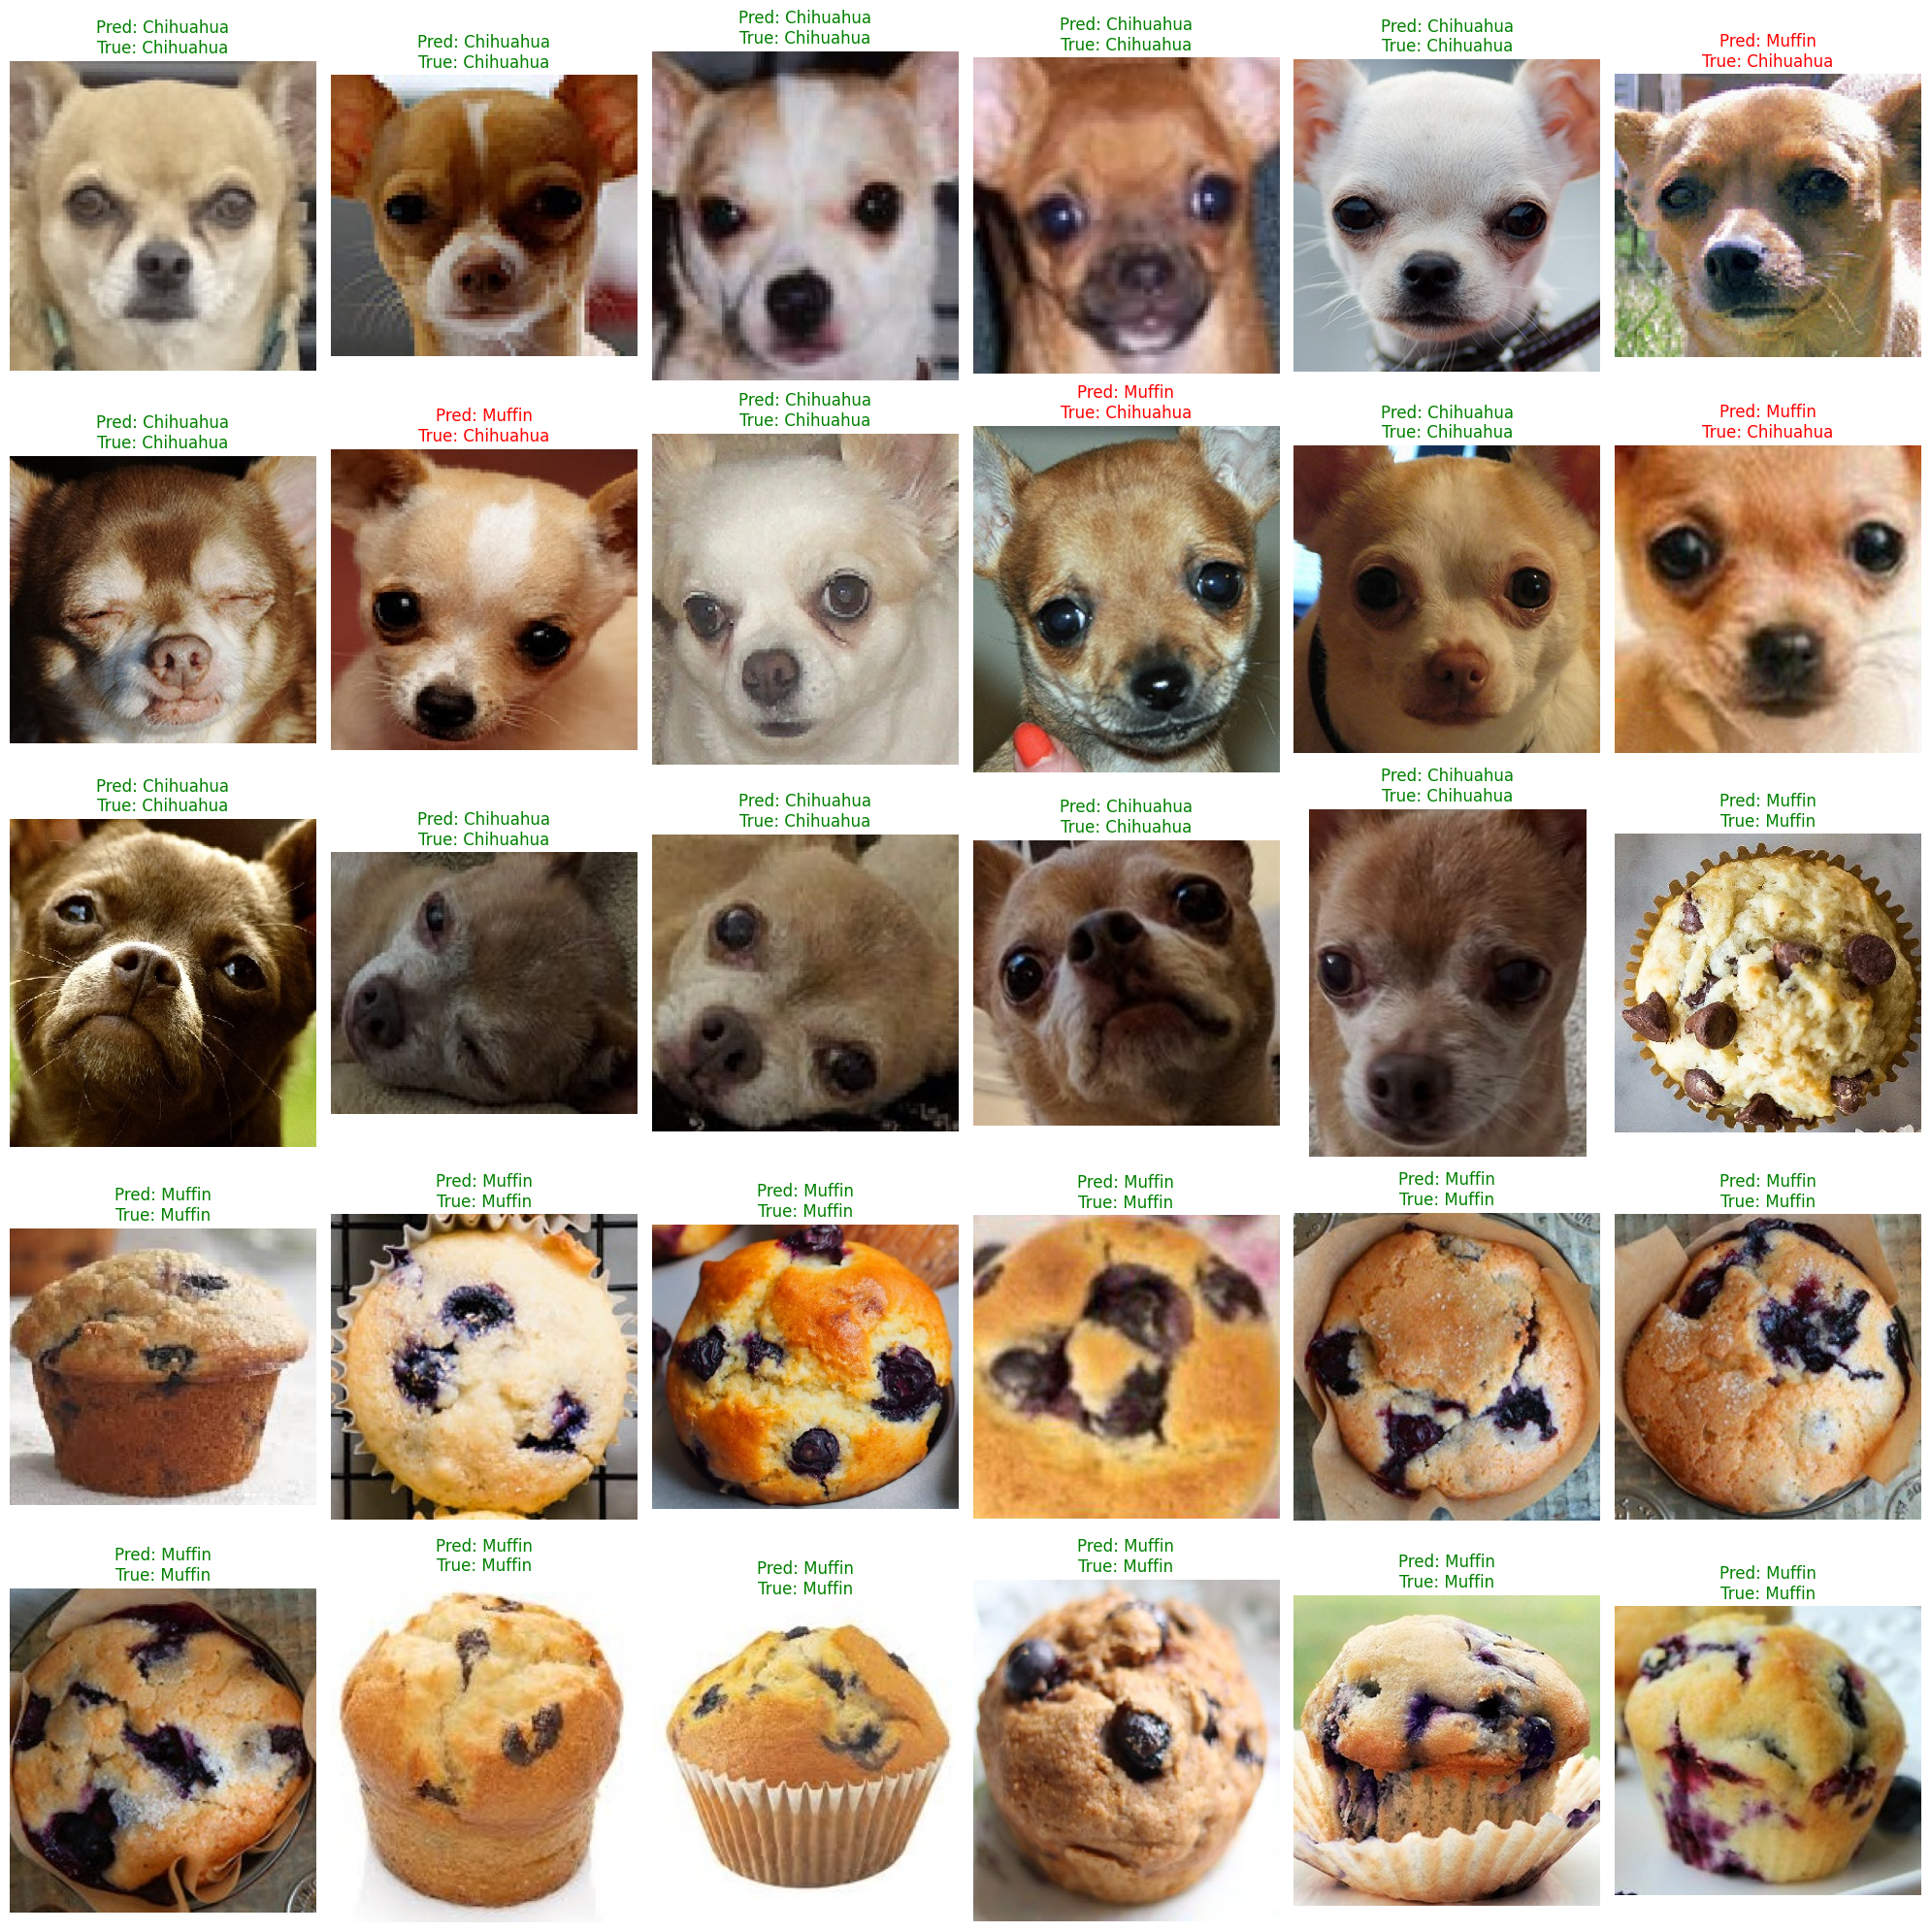

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

# Get predictions
val_preds, val_labels = evaluate_model(trained_model, dataloaders['validation'])

# Calculate accuracy
accuracy = sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

# Visualize some predictions
def plot_results(images, preds, labels):
    fig, axs = plt.subplots(5, 6, figsize=(20, 20))
    for i, (img_path, pred, label) in enumerate(zip(image_datasets['validation'].imgs, preds, labels)):
        img = plt.imread(img_path[0])
        ax = axs[i // 6, i % 6]
        ax.imshow(img)
        ax.axis('off')
        color = 'green' if pred == label else 'red'
        ax.set_title(f"Pred: {'Chihuahua' if pred == 0 else 'Muffin'}\nTrue: {'Chihuahua' if label == 0 else 'Muffin'}", color=color)
    plt.tight_layout()
    plt.show()

plot_results(image_datasets['validation'].imgs, val_preds, val_labels)

# 8.  Conclusion and Reflection

Congratulations! You've successfully built, trained, and evaluated a CNN for classifying Chihuahuas and Muffins. Here are some reflection questions to consider:

How does the performance of this CNN compare to the traditional Neural Network from the previous workshop?
What role do the convolutional layers play in image classification?
How might you further improve this model's performance?
What challenges might this model face in real-world applications?
How does data augmentation (like random flips and rotations) contribute to the model's performance?
What are the ethical considerations in developing and deploying an image classification system like this?

Remember to support your answers with references to relevant literature or resources on deep learning and computer vision. Good luck with your reflective journal!

 If you want  you can play with some hyperparameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# 9. Experiment and Analyze

In this section, I'll show you how to try different things with your model to see how they change its performance. This is where I get to experiment!

The main idea is to change some settings of the model or how I train it and then see if it gets better at telling Chihuahuas from muffins.

Here are some ways I can help you experiment:

*   **Change the number of training steps (epochs):** I can train the model for more or fewer rounds to see how that affects the results. Sometimes training for too long can make the model too focused on the training pictures and not as good with new ones. I can adjust the `num_epochs` parameter in the `train_model` function to do this. A higher number means more training rounds, while a lower number means fewer.
*   **Adjust the learning rate:** The learning rate is like the size of the steps the model takes when learning. I can make these steps bigger or smaller to see if it learns faster or more accurately. I can change the `lr` parameter in the `optim.Adam` optimizer when I set it up. A larger learning rate means bigger steps, and a smaller learning rate means smaller steps.
*   **Change the model's structure:** The model has different layers that process the images, like the convolutional layers and the fully connected layers. I can add or remove some of these layers, or change how many units are in each layer, to see if a different structure works better. This involves changing the `ChihuahuaMuffinCNN` class definition itself.

After I make these changes and train the model again, I can show you how the new results compare to the original ones. This helps me understand which changes make the model perform better.

## 9.1 Modify the training function
**Reasoning:** I changed the train_model function to return the training and validation loss and accuracy for each step (epoch) so I can better analyze how the model learns and compare different tries.

I updated the function to include empty lists at the beginning to store these values for each epoch. After calculating the loss and accuracy for each phase (training or validation) in every epoch, I added those numbers to the appropriate lists. Finally, I made the function return these lists along with the trained model. This lets me see the model's performance develop over time, which is key for understanding the experiments.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())


        print()

    return model, train_losses, train_accuracies, val_losses, val_accuracies

# Train the model
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

print("Training complete!")

Epoch 1/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.52s/it]


train Loss: 0.1102 Acc: 0.9667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


validation Loss: 0.0704 Acc: 1.0000

Epoch 2/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]


train Loss: 0.1291 Acc: 0.9417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


validation Loss: 0.5140 Acc: 0.7333

Epoch 3/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.56s/it]


train Loss: 0.1674 Acc: 0.9667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


validation Loss: 0.0693 Acc: 1.0000

Epoch 4/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.55s/it]


train Loss: 0.1254 Acc: 0.9583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


validation Loss: 0.0768 Acc: 1.0000

Epoch 5/10
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.40s/it]


train Loss: 0.0566 Acc: 0.9917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


validation Loss: 0.3261 Acc: 0.8333

Epoch 6/10
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.36s/it]


train Loss: 0.0879 Acc: 0.9750


validation: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


validation Loss: 0.1248 Acc: 0.9667

Epoch 7/10
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.42s/it]


train Loss: 0.0282 Acc: 1.0000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


validation Loss: 0.0519 Acc: 1.0000

Epoch 8/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.67s/it]


train Loss: 0.0441 Acc: 0.9833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


validation Loss: 0.0996 Acc: 0.9333

Epoch 9/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


train Loss: 0.0214 Acc: 0.9917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


validation Loss: 0.2076 Acc: 0.9000

Epoch 10/10
----------


train: 100%|██████████| 4/4 [00:25<00:00,  6.36s/it]


train Loss: 0.0339 Acc: 0.9917


validation: 100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

validation Loss: 0.0947 Acc: 0.9667

Training complete!


## 9.2 Visualize training progress
**Reasoning:** This code plots the training and validation loss and accuracy over epochs

This code uses `matplotlib` to create two plots side-by-side. The first plot shows how the training and validation loss changed over each epoch. The second plot shows how the training and validation accuracy changed over each epoch. It uses the lists of loss and accuracy values returned by the modified `train_model` function to draw these lines. These plots help me visually understand how well the model learned and if there are signs of issues like overfitting.

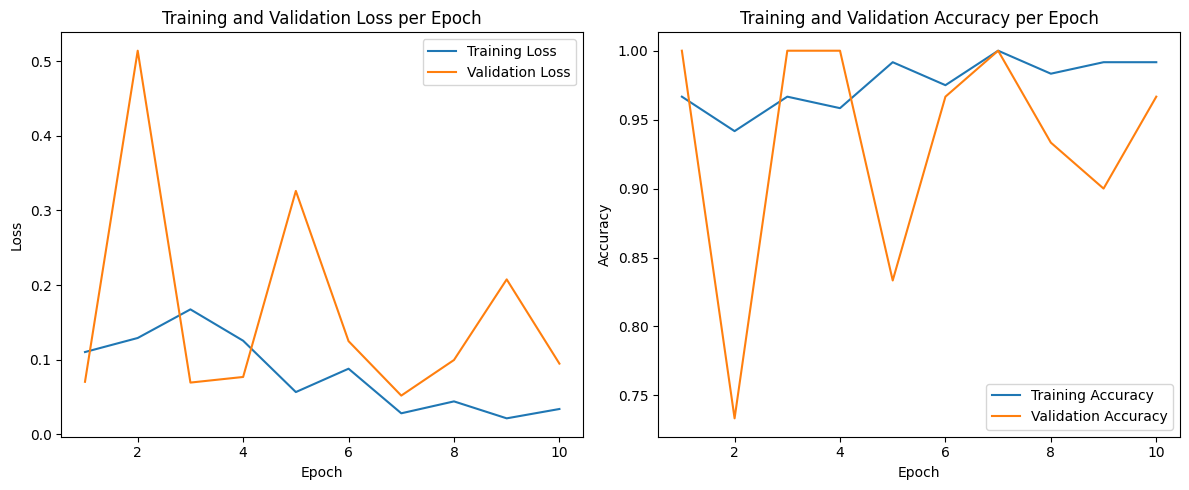

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 9.3 Experiment with hyperparameters

**Reasoning:** I want to see how changing some model settings affects its performance, so I'm setting up a new experiment with different hyperparameters.

I defined new values for the number of training steps and the learning rate in the code. Then, I created a new model and set up the learning process with these new values. I trained this new model using the training function and saved the results separately. This lets me compare this experiment to the first run to see which settings work better.

In [ ]:
# Define new hyperparameter values
new_num_epochs = 20  # Increase epochs
new_lr = 0.0005      # Decrease learning rate

# Re-initialize the model with the same architecture
model_experiment = ChihuahuaMuffinCNN().to(device)

# Define the criterion (Cross Entropy Loss)
criterion_experiment = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with the new learning rate
optimizer_experiment = optim.Adam(model_experiment.parameters(), lr=new_lr)

print("Starting training experiment with:")
print(f"  Number of epochs: {new_num_epochs}")
print(f"  Learning rate: {new_lr}")
print()

# Train the model with the new hyperparameters and store results in new variables
trained_model_experiment, train_losses_experiment, train_accuracies_experiment, val_losses_experiment, val_accuracies_experiment = train_model(
    model_experiment, dataloaders, criterion_experiment, optimizer_experiment, num_epochs=new_num_epochs
)

print("Training experiment complete!")

Starting training experiment with:
  Number of epochs: 20
  Learning rate: 0.0005

Epoch 1/20
----------


train: 100%|██████████| 4/4 [00:25<00:00,  6.29s/it]


train Loss: 3.5913 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.8444 Acc: 0.4333

Epoch 2/20
----------


train: 100%|██████████| 4/4 [00:23<00:00,  5.80s/it]


train Loss: 0.8786 Acc: 0.5833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.5343 Acc: 0.9000

Epoch 3/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]


train Loss: 0.6367 Acc: 0.6333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


validation Loss: 0.4939 Acc: 0.9333

Epoch 4/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.58s/it]


train Loss: 0.5230 Acc: 0.7417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.3946 Acc: 0.9000

Epoch 5/20
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.49s/it]


train Loss: 0.3691 Acc: 0.8333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


validation Loss: 0.2353 Acc: 0.9000

Epoch 6/20
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.31s/it]


train Loss: 0.2335 Acc: 0.8750


validation: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


validation Loss: 0.1167 Acc: 0.9667

Epoch 7/20
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.36s/it]


train Loss: 0.2216 Acc: 0.9000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.2775 Acc: 0.8667

Epoch 8/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.64s/it]


train Loss: 0.1606 Acc: 0.9417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


validation Loss: 0.0976 Acc: 0.9667

Epoch 9/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


train Loss: 0.1183 Acc: 0.9583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.1012 Acc: 0.9667

Epoch 10/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.67s/it]


train Loss: 0.1114 Acc: 0.9583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 0.2258 Acc: 0.8667

Epoch 11/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.57s/it]


train Loss: 0.1158 Acc: 0.9833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


validation Loss: 0.0491 Acc: 1.0000

Epoch 12/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.54s/it]


train Loss: 0.1105 Acc: 0.9500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


validation Loss: 0.1394 Acc: 0.9667

Epoch 13/20
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.34s/it]


train Loss: 0.0833 Acc: 0.9750


validation: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


validation Loss: 0.0514 Acc: 0.9667

Epoch 14/20
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.32s/it]


train Loss: 0.0803 Acc: 0.9667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


validation Loss: 0.0604 Acc: 0.9667

Epoch 15/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


train Loss: 0.0268 Acc: 0.9917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.1223 Acc: 0.9667

Epoch 16/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


train Loss: 0.0282 Acc: 1.0000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.0556 Acc: 1.0000

Epoch 17/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]


train Loss: 0.0188 Acc: 1.0000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


validation Loss: 0.1008 Acc: 0.9333

Epoch 18/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


train Loss: 0.0309 Acc: 0.9917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 0.0741 Acc: 0.9667

Epoch 19/20
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


train Loss: 0.0085 Acc: 1.0000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


validation Loss: 0.0312 Acc: 1.0000

Epoch 20/20
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.50s/it]


train Loss: 0.0135 Acc: 0.9917


validation: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

validation Loss: 0.0557 Acc: 0.9667

Training experiment complete!


## 9.4 Analyze and compare results

**Reasoning:** I want to compare how well the model performed in my first try versus the second try with different settings.

In the code, I used the data I saved from both training runs to draw pictures. These pictures show how the model's mistakes and correctness changed over time for both tries. Looking at these plots helps me understand if changing the settings made the model learn better or worse.

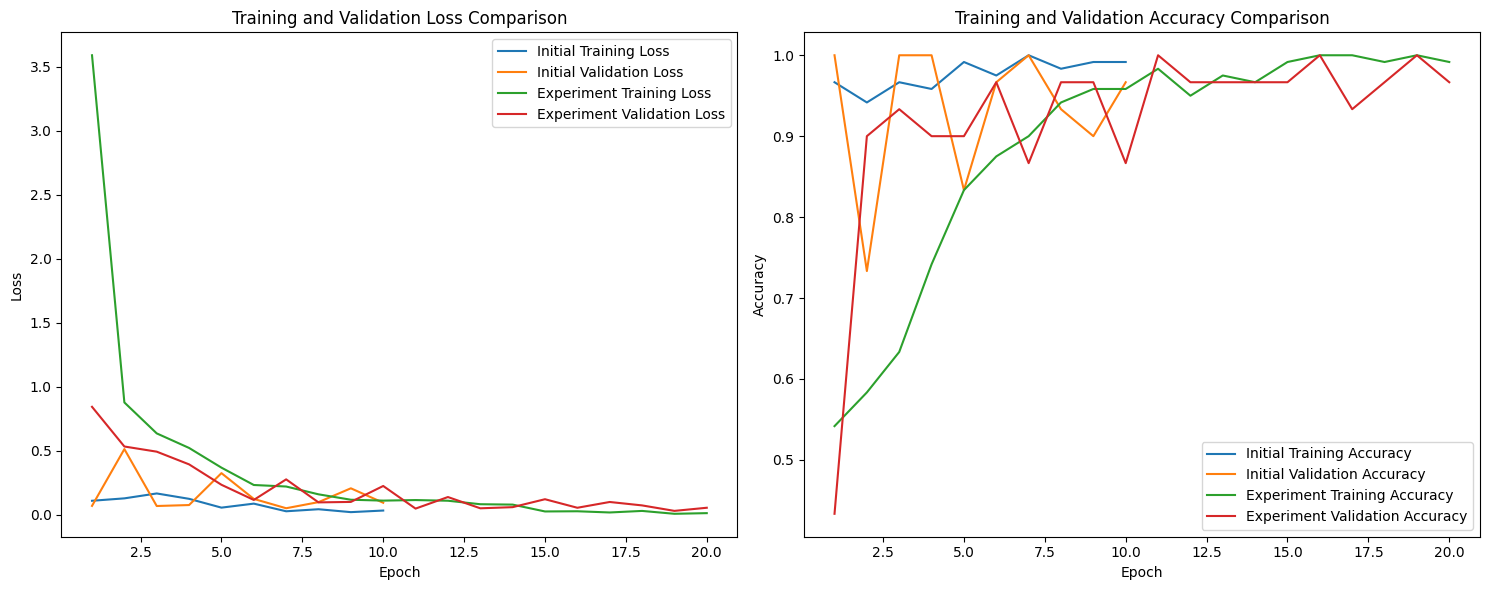

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training and validation loss comparison
epochs_initial = range(1, len(train_losses) + 1)
epochs_experiment = range(1, len(train_losses_experiment) + 1)

axs[0].plot(epochs_initial, train_losses, label='Initial Training Loss')
axs[0].plot(epochs_initial, val_losses, label='Initial Validation Loss')
axs[0].plot(epochs_experiment, train_losses_experiment, label='Experiment Training Loss')
axs[0].plot(epochs_experiment, val_losses_experiment, label='Experiment Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss Comparison')
axs[0].legend()

# Plot training and validation accuracy comparison
axs[1].plot(epochs_initial, train_accuracies, label='Initial Training Accuracy')
axs[1].plot(epochs_initial, val_accuracies, label='Initial Validation Accuracy')
axs[1].plot(epochs_experiment, train_accuracies_experiment, label='Experiment Training Accuracy')
axs[1].plot(epochs_experiment, val_accuracies_experiment, label='Experiment Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy Comparison')
axs[1].legend()

plt.tight_layout()
plt.show()

# **Analysis of Hyperparameter Experiment Results**

I will analyze the results of the hyperparameter experiment. The first experiment used the original notebook code with 10 epochs and a learning rate of 0.001. My experiment, in Section 9 and specifically Section 9.3, used 20 epochs and a learning rate of 0.0005. The plots in Section 9.4 show the training and validation loss and accuracy over epochs for both experiments. This helps me analyze the changes in model performance.

## **Comparison of Results**

**Training Loss Comparison:**

In both the original run and my experiment, the training loss went down over time. This means the model learned from the training data. In my experiment with a lower learning rate, the training loss went down more smoothly. The loss line in the first try jumped around more. This suggests the larger learning rate might have made the learning less steady.

**Validation Loss Comparison:**

The validation loss also went down in both tries. This shows my model got better at understanding new pictures. In the original run, the validation loss went down at first but then started to go up and down after about 7 epochs. This can mean the model was starting to remember the training data too much, which is called overfitting. In my experiment, the validation loss stayed low and steady for a longer time. This means my changes helped the model work better on new data for a longer period. However, the validation loss did go up a little at the very end of my experiment, after epoch 17. This suggests some overfitting might still happen if training goes on too long.

**Training Accuracy Comparison:**

The training accuracy went up steadily in both the original run and my experiment. The model got better at correctly identifying the training pictures. In my experiment with more epochs (Section 9.3), the training accuracy got very close to 100%. This shows the model could learn the training data very well.

**Validation Accuracy Comparison:**

The validation accuracy also went up quickly in both experiments. In the original run, the accuracy got high fast but then went up and down a lot. This matches the validation loss behavior and suggests instability. In my experiment, the validation accuracy also got high fast and stayed high and steady for a longer time. It even reached 100% in some epochs. This shows my changes led to a model that works better on new data for a longer time. The accuracy went down a little at the very end of my experiment, after epoch 17. This means the model might still overfit if trained too much.

## **Conclusion**

Based on the plots in Section 9.4, my experiment with 20 epochs and a learning rate of 0.0005 improved the model's performance and how well it worked on new data compared to the original run. The lower learning rate helped the training be more stable. More epochs helped the model learn more and keep the validation accuracy high for longer.

However, both experiments show that overfitting can happen, especially in later epochs. When the validation loss starts to go up and the accuracy jumps around, it is a sign of overfitting. To make the model even better and stop overfitting, I can try other things. I could stop training early if the validation loss goes up. addtional change the learning rate during training to make it smaller over time. also add things to the model to help it not focus too much on the training data. Using more ways to change the training pictures could also help the model work better on new data. By trying different settings and methods, I can make the Chihuahua vs Muffin classifier work even better.

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
I've modified it significantly to cater to this Lab.

The original tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.